In [37]:
setwd('/import/DB/zhang//data')

In [38]:
# sce1 = readRDS('OS.final.rds')
# Idents(sce1) = 'celltype'
# table(sce1$celltype)
# sce1  = subset(sce1,idents = c('OBs','OS1','OS2','BMSC'))
# library(Seurat)
# Idents(sce1) = 'group'
# table(sce1$group)
# sce1 = subset(sce1,idents = 'OS')
# Idents(sce1) = 'celltype'
# DimPlot(sce1,label = T,reduction = 'umap')

In [40]:
load('forslingshot.rda')

In [41]:
sce1 = sce

In [42]:
library(Seurat)

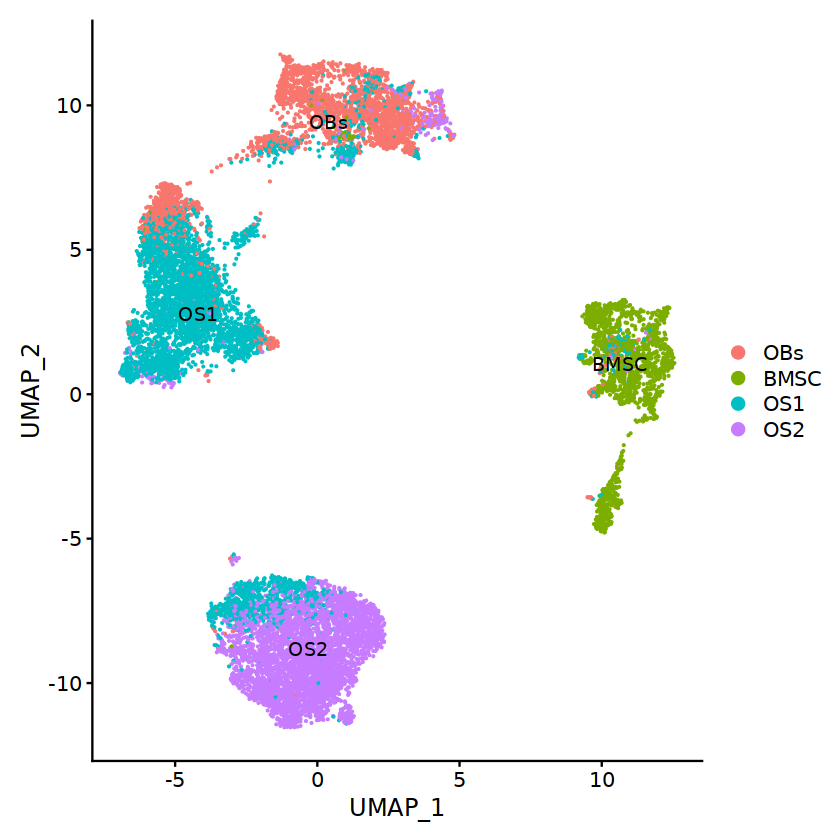

In [50]:
Idents(sce1) = 'celltype'
DimPlot(sce1,label = T,reduction = 'umap')

### 时间分析

In [62]:
scRNA = sce1

In [64]:
scRNA$celltype = factor(scRNA$celltype,levels = c('BMSC','OBs','OS1','OS2'))

In [66]:
DefaultAssay(scRNA) = 'RNA'

In [67]:
Idents(scRNA) = 'celltype'
sce.markers <- FindAllMarkers(object = scRNA, only.pos = TRUE, 
                              min.pct = 0.25, thresh.use = 0.25)
library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)

Calculating cluster BMSC

Calculating cluster OBs

Calculating cluster OS1

Calculating cluster OS2



In [68]:
gene_cell_exp <- AverageExpression(scRNA,
                                   features = unique(top5$gene),
                                   group.by = 'celltype',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)

In [70]:
library(ComplexHeatmap)
#顶部细胞类型注释
df <- data.frame(colnames(gene_cell_exp))
colnames(df) <- 'class'

In [71]:


top_anno = HeatmapAnnotation(df = df,#细胞名/cluster
                             border = T,
                             show_annotation_name = F,
                             gp = gpar(col = 'black'),
                             col = list(class = c( 'BMSC'="#2F528F", 'OBs'="#F6F5B4",  "OS1"="#067756",
                                                  "OS2"="#E3AD68")))#颜色设置

In [72]:
#数据标准化缩放一下
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))

In [76]:
options(repr.plot.height = 7,repr.plot.width = 5)

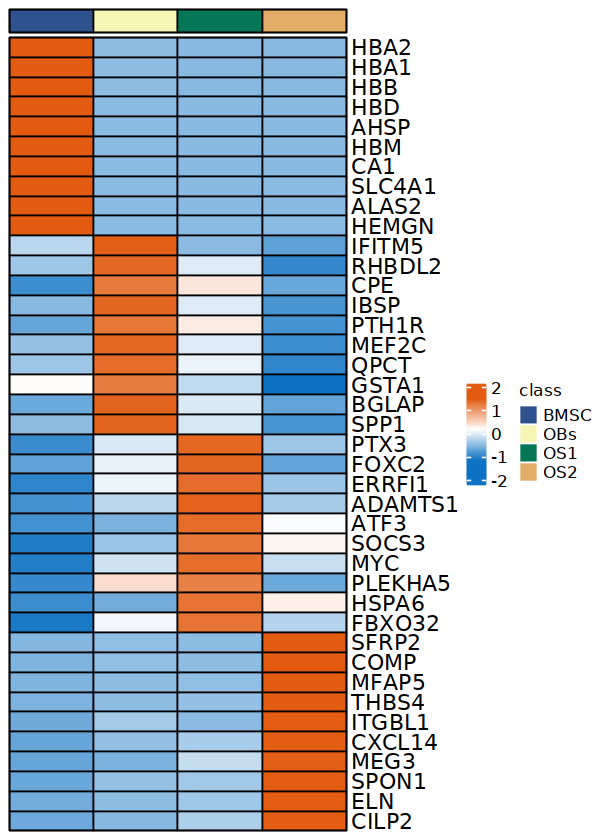

In [77]:
Heatmap(marker_exp,
        cluster_rows = F,
        cluster_columns = F,
        show_column_names = F,
        show_row_names = T,
        column_title = NULL,
        heatmap_legend_param = list(
          title=' '),
        col = colorRampPalette(c("#0D72C3","white","#E35B10"))(100),
        border = 'black',
        rect_gp = gpar(col = "black", lwd = 1),
        row_names_gp = gpar(fontsize = 13),
        column_names_gp = gpar(fontsize = 13),
        top_annotation = top_anno)

In [79]:
library(GSVA)
library(tidyverse)
library(org.Hs.eg.db)
Idents(scRNA) <- "celltype" 
expr <- AverageExpression(scRNA, assays = "RNA", slot = "data")[[1]]
expr <- expr[rowSums(expr)>0,]  #过滤细胞表达量全为零的基因
expr <- as.matrix(expr)
# library(msigdbr)
# msigdbr_species() #列出有的物种

In [81]:
d = '/import/DB' 
gmtfs <- list.files(d,pattern = '.gmt')  # 路径下所有结尾为symbols.gmt文件
gmtfs
library(GSEABase)
kegg_list <- getGmt(file.path(d,gmtfs[3])) 
go_list <- getGmt(file.path(d,gmtfs[1])) 
hall_list <- getGmt(file.path(d,gmtfs[2])) 

[1] "BP.gmt"                   "h.all.v7.5.1.symbols.gmt"
[3] "kegg.gmt"

Warning message in getGmt(file.path(d, gmtfs[1])):
"2 record(s) contain duplicate ids: GOBP_CIRCULATORY_SYSTEM_DEVELOPMENT, GOBP_PROTEOLYSIS_INVOLVED_IN_PROTEIN_CATABOLIC_PROCESS"


In [82]:
human_KEGG_Set = hall_list
# #选择基因集合
# human_KEGG = msigdbr(species = "Homo sapiens", #物种
#                       category = "C2",
#                      subcategory = "KEGG") %>% 
#   dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol或者ID
# human_KEGG_Set = human_KEGG %>% split(x = .$gene_symbol, f = .$gs_name)
library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian",
             method = "gsva",
             parallel.sz=1)
head(gsva.kegg)

dim(gsva.kegg)

a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(10) %>%  rownames()
    a = unique(c(a,path))
 }
gsva.kegg = gsva.kegg[a,]
options(repr.plot.width = 9,repr.plot.height =  8)
rownames(gsva.kegg) = gsub('HALLMARK_','',rownames(gsva.kegg))

rownames(gsva.kegg)= tolower(rownames(gsva.kegg))

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


Estimating GSVA scores for 50 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,BMSC,OBs,OS1,OS2
HALLMARK_ADIPOGENESIS,0.17296320,0.07215810,-0.2525943,-0.1220687
HALLMARK_ALLOGRAFT_REJECTION,0.26053790,-0.11046505,-0.3448976,0.1345671
HALLMARK_ANDROGEN_RESPONSE,-0.10054439,-0.19042801,0.1370826,0.1744922
HALLMARK_ANGIOGENESIS,-0.40599310,0.05905738,0.1037317,0.2755630
HALLMARK_APICAL_JUNCTION,-0.13843731,-0.15766175,-0.1884303,0.2690280
HALLMARK_APICAL_SURFACE,-0.01730939,-0.18223367,0.2484387,0.1994113


[1] 50  4

In [84]:
options(repr.plot.height = 7,repr.plot.width = 6)

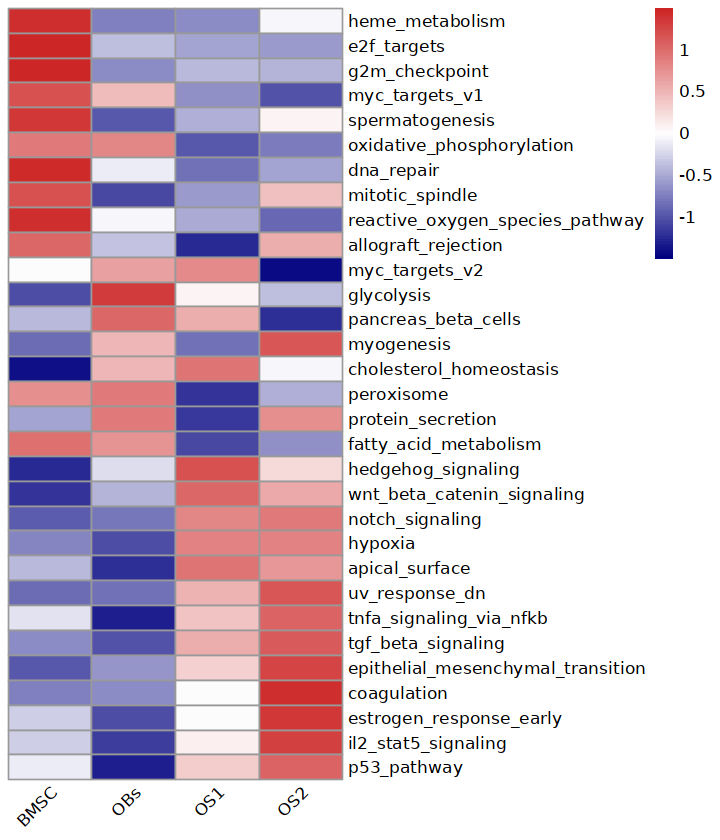

In [85]:
library(pheatmap)
p = pheatmap(as.matrix(gsva.kegg), scale = "row",angle_col = "45",cluster_cols  = FALSE,cluster_rows = FALSE,
        show_column_names = F,
        show_row_names = T,
         color = colorRampPalette(c("navy", "white", "firebrick3"))(100))

In [88]:
library(msigdbr)

Warning message:
"package 'msigdbr' was built under R version 4.2.3"


In [89]:
#human_KEGG_Set = kegg_list
# #选择基因集合
human_KEGG = msigdbr(species = "Homo sapiens", #物种
                      category = "C2",
                     subcategory = "KEGG") %>% 
  dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol或者ID
human_KEGG_Set = human_KEGG %>% split(x = .$gene_symbol, f = .$gs_name)
library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian",
             method = "gsva",
             parallel.sz=1)
head(gsva.kegg)
dim(gsva.kegg)
a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(10) %>%  rownames()
    a = unique(c(a,path))
 }
gsva.kegg = gsva.kegg[a,]
options(repr.plot.width = 9,repr.plot.height =  8)
rownames(gsva.kegg) = gsub('KEGG_','',rownames(gsva.kegg))
rownames(gsva.kegg)= tolower(rownames(gsva.kegg))

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


Estimating GSVA scores for 186 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,BMSC,OBs,OS1,OS2
KEGG_ABC_TRANSPORTERS,-0.174405159,-0.24570135,-0.39772957,-0.10862671
KEGG_ACUTE_MYELOID_LEUKEMIA,0.005349069,-0.18657567,-0.18529315,0.05050431
KEGG_ADHERENS_JUNCTION,-0.166650084,-0.32396361,-0.14177372,0.00592720
KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY,-0.076451729,-0.31801879,-0.44728488,-0.10030508
KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,0.094176197,-0.02921424,0.02950169,-0.43547058
KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION,-0.020023514,-0.22186803,0.16678840,0.14087990


[1] 186   4

In [93]:
options(repr.plot.height = 7,repr.plot.width = 7)

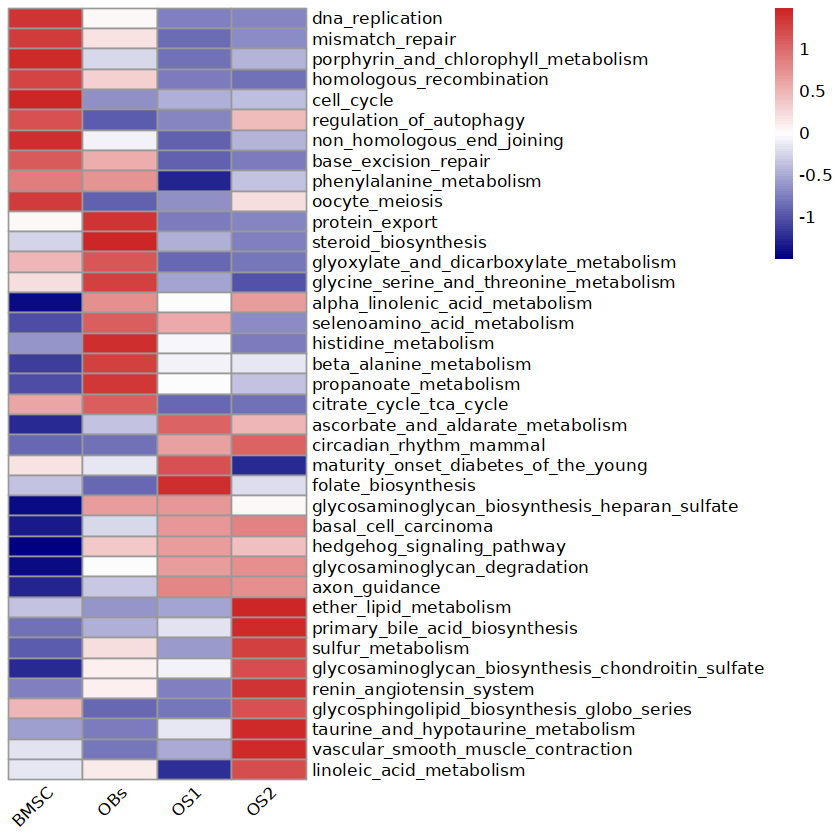

In [94]:
library(pheatmap)
p = pheatmap(as.matrix(gsva.kegg), scale = "row",angle_col = "45",cluster_cols  = FALSE,cluster_rows = FALSE,
        show_column_names = F,
        show_row_names = T,
         color = colorRampPalette(c("navy", "white", "firebrick3"))(100))

In [95]:
# GO

In [126]:
#human_KEGG_Set = go_list
# #选择基因集合
human_KEGG = msigdbr(species = "Homo sapiens", #物种
                      category = "C5",
                     subcategory = "BP") %>% 
  dplyr::select(gs_name,gene_symbol)#这里可以选择gene symbol或者ID
human_KEGG_Set = human_KEGG %>% split(x = .$gene_symbol, f = .$gs_name)
library(GSVA)
gsva.kegg <- gsva(expr, gset.idx.list = human_KEGG_Set, 
             kcdf="Gaussian",
             method = "gsva",
             parallel.sz=1)
head(gsva.kegg)
dim(gsva.kegg)
a = c()
ds = as.data.frame(gsva.kegg) 
for (i in 1:dim(ds)[2] ){
    path = ds[ order (-ds[,i]),] %>%  head(10) %>%  rownames()
    a = unique(c(a,path))
 }

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message in .gsva(expr, mapped.gset.idx.list, method, kcdf, rnaseq, abs.ranking, :
"Some gene sets have size one. Consider setting 'min.sz > 1'."


Estimating GSVA scores for 7652 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



,BMSC,OBs,OS1,OS2
GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS,-0.002104093,0.7538824808,-0.29942694,-0.23995272
GOBP_2FE_2S_CLUSTER_ASSEMBLY,-0.036602187,-0.2993334458,-0.03557034,0.05908077
GOBP_2_OXOGLUTARATE_METABOLIC_PROCESS,0.188293262,0.4165099621,-0.48674696,-0.34608850
GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_BIOSYNTHETIC_PROCESS,-0.722151107,-0.0110218652,0.35065976,0.46710215
GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_METABOLIC_PROCESS,-0.503062724,0.0007359795,-0.05096853,0.41470298
GOBP_3_UTR_MEDIATED_MRNA_DESTABILIZATION,-0.118889309,-0.3179210508,0.31119969,-0.37350866


[1] 7652    4

In [127]:
gsva.kegg = gsva.kegg[a,]
options(repr.plot.width = 9,repr.plot.height =  8)
rownames(gsva.kegg) = gsub('GOBP_','',rownames(gsva.kegg))
rownames(gsva.kegg)= tolower(rownames(gsva.kegg))

In [134]:
gsva.kegg1 = gsva.kegg[-24,]

In [137]:
options(repr.plot.height = 7,repr.plot.width = 9)

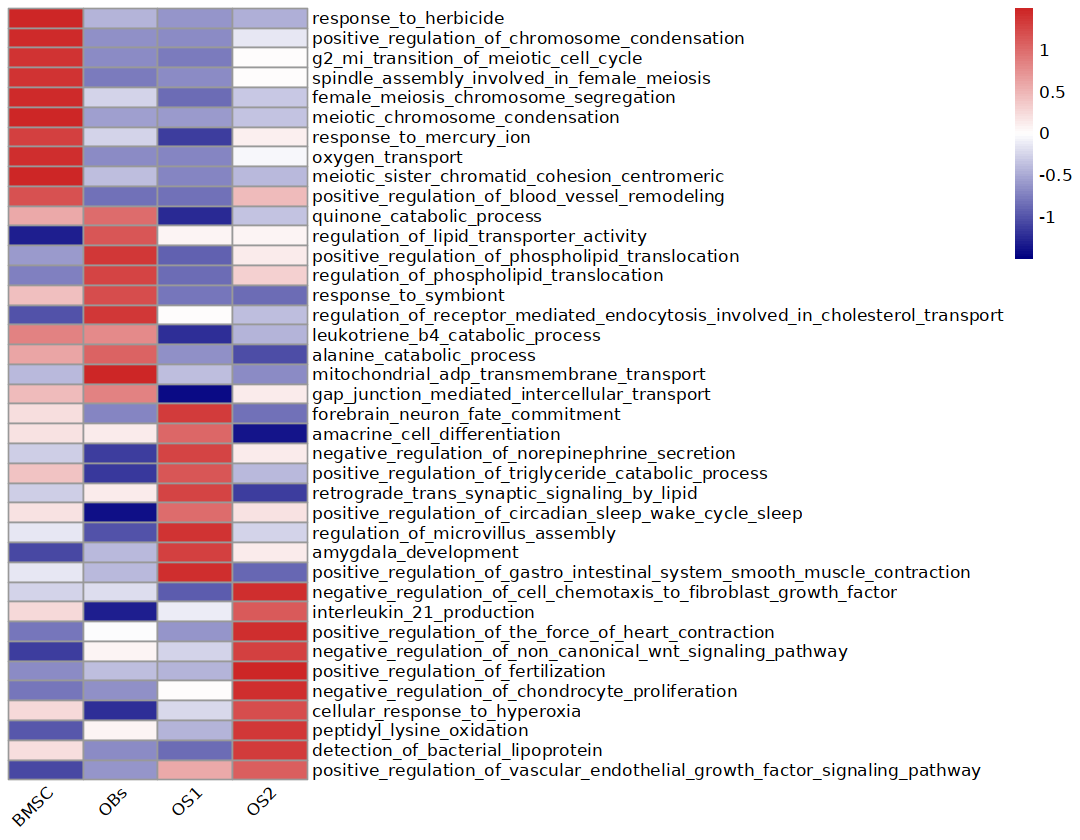

In [138]:
library(pheatmap)
p = pheatmap(as.matrix(gsva.kegg1), scale = "row",angle_col = "45",cluster_cols  = FALSE,cluster_rows = FALSE,
        show_column_names = F,
        show_row_names = T,
         color = colorRampPalette(c("navy", "white", "firebrick3"))(100))

In [45]:
library(slingshot)
library(Seurat)
library(devtools)
library(cowplot)
library(ggplot2)
library(Matrix)
library(dplyr)
library(tradeSeq)
library(RColorBrewer)
library(DelayedMatrixStats)
library(scales)
library(paletteer) 
library(viridis)
sce <- as.SingleCellExperiment(sce1, assay = "RNA")

In [46]:
sce_slingshot1 <- slingshot(sce,      #输入单细胞对象
                     reducedDim = 'UMAP',  #降维方式
                     clusterLabels = sce$seurat_clusters,  #cell类型
                     start.clus = '5',       #轨迹起点,也可以不定义
                     approx_points = 150)

SlingshotDataSet(sce_slingshot1) 

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."


class: SlingshotDataSet 

 Samples Dimensions
   14001          2

lineages: 1 
Lineage1: 5  3  2  4  1  0  

curves: 1 
Curve1: Length: 44.268	Samples: 14001

In [47]:
cell_pal <- function(cell_vars, pal_fun,...) {
  if (is.numeric(cell_vars)) {
    pal <- pal_fun(100, ...)
    return(pal[cut(cell_vars, breaks = 100)])
  } else {
    categories <- sort(unique(cell_vars))
    pal <- setNames(pal_fun(length(categories), ...), categories)
    return(pal[cell_vars])
  }
}

In [48]:
# ### https://www.jianshu.com/p/e85d23a25a43
# cell_colors <- cell_pal(sce_slingshot1$seurat_clusters, brewer_pal("qual", "Set2"))
# plot(reducedDims(sce_slingshot1)$TSNE, col = cell_colors, pch=16, asp = 1, cex = 0.8)
# lines(SlingshotDataSet(sce_slingshot1), lwd=2, col='black')
# celltype_label <- sce1@reductions$tsne@cell.embeddings%>% 
#   as.data.frame() %>%
#   cbind(celltype = sce1@meta.data$seurat_clusters) %>%
#   group_by(celltype) %>%
#   summarise(TSNE1 = median(tSNE_1),
#             TSNE2 = median(tSNE_2))

# for (i in 1:8) {
#   text(celltype_label$celltype[i], x=celltype_label$TSNE1[i]-1, y=celltype_label$TSNE2[i])
# }

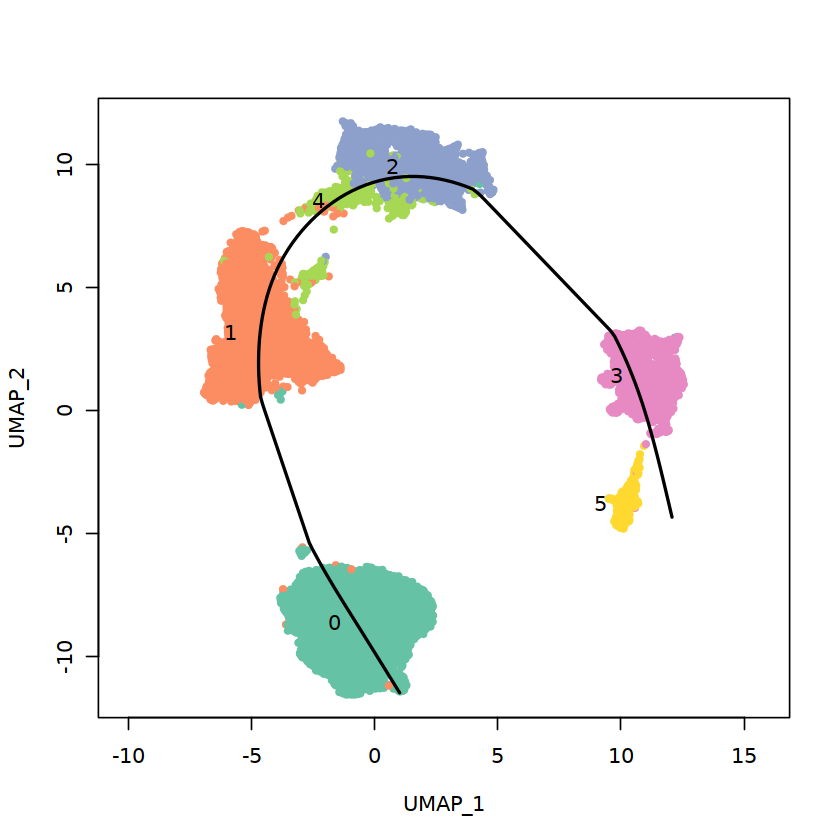

In [49]:
### https://www.jianshu.com/p/e85d23a25a43
cell_colors <- cell_pal(sce_slingshot1$seurat_clusters, brewer_pal("qual", "Set2"))
plot(reducedDims(sce_slingshot1)$UMAP, col = cell_colors, pch=16, asp = 1, cex = 0.8)
lines(SlingshotDataSet(sce_slingshot1), lwd=2, col='black')
celltype_label <- sce1@reductions$umap@cell.embeddings%>% 
  as.data.frame() %>%
  cbind(celltype = sce1@meta.data$seurat_clusters) %>%
  group_by(celltype) %>%
  summarise(UMAP1 = median(UMAP_1),
            UMAP2 = median(UMAP_2))

for (i in 1:8) {
  text(celltype_label$celltype[i], x=celltype_label$UMAP1[i]-1, y=celltype_label$UMAP2[i])
}

In [54]:
slingsce<-SlingshotDataSet(sce_slingshot1)
pseudotimeED <- slingPseudotime(slingsce, na = FALSE)
cellWeightsED <- slingCurveWeights(slingsce)
counts<-sce_slingshot1@assays@data@listData$counts

In [55]:
gene = sce1@assays$RNA@var.features

In [56]:
counts<-sce_slingshot1@assays@data@listData$counts[gene,]

In [57]:
#这里用的书所有的基因
sce_slinghot <- fitGAM(counts = counts, pseudotime = pseudotimeED, cellWeights = cellWeightsED, nknots = 5, verbose = T)
mean(rowData(sce_slinghot)$tradeSeq$converged)
rowData(sce_slinghot)$assocRes <- associationTest(sce_slinghot, lineages = TRUE, l2fc = log2(2))

assocRes <- rowData(sce_slinghot)$assocRes

[1] 0.996

In [59]:
options(repr.plot.width = 8)

Warning message:
"CombinePlots is being deprecated. Plots should now be combined using the patchwork system."


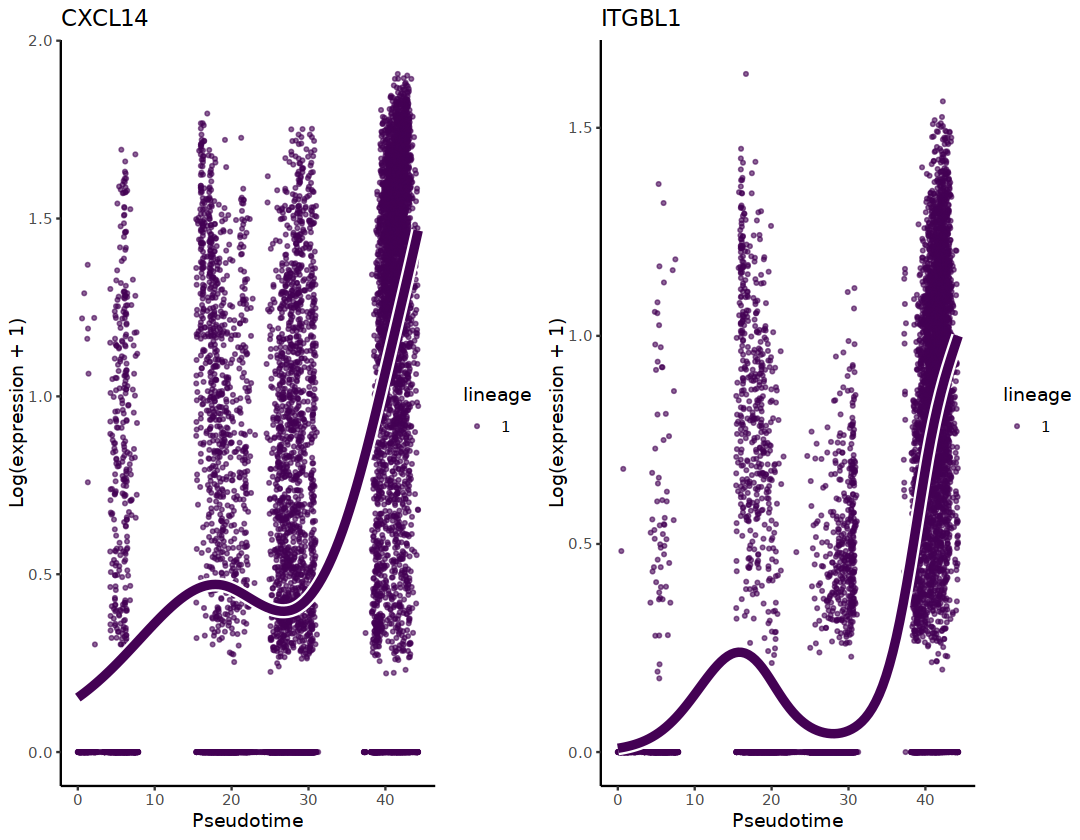

In [140]:
gene_dynamic <- list()
genes_plot <- c("CXCL14",'ITGBL1')
for(i in 1:length(genes_plot)){
  p = plotSmoothers(sce_slinghot, assays(sce_slinghot)$counts,
                    gene =genes_plot[i], alpha = 0.6, border = T, lwd = 2)+
    ggtitle(genes_plot[i])
  gene_dynamic[[i]] <- p
}

Seurat::CombinePlots(gene_dynamic, ncol = 2)

In [141]:
pseudotime = slingPseudotime(sce_slingshot1)%>% as.data.frame() 
Lineages = colnames(pseudotime)
for(i in c(1)){
  pseudotime_sub <- pseudotime[,i]
  sce1 <- AddMetaData(object = sce1,
                   metadata = pseudotime_sub,
                   col.name = Lineages[i])
}
mouse_data = sce1

In [142]:
sce_slingshot1$sling_pseudotime = sce_slingshot1[[paste0("slingPseudotime_1")]]
mouse_data$sling_pseudotime = sce_slingshot1$sling_pseudotime

#仅分析在轨迹拟时中的细胞，去除NA
sce_slingshot1_l1 = sce_slingshot1[,!is.na(sce_slingshot1$sling_pseudotime)]
seur = mouse_data[,!is.na(mouse_data$sling_pseudotime)]

In [143]:


#和前面一样这一步会比较慢，这个数据跑了大概1个小时。
sce_slingshot1_l1 <- fitGAM(counts(sce_slingshot1_l1), 
                            cellWeights = rep(1, ncol(sce_slingshot1_l1)), 
                            pseudotime = sce_slingshot1_l1$sling_pseudotime)

ATres <- associationTest(sce_slingshot1_l1)
association_test_tab = as_tibble(cbind(gene = rownames(ATres), ATres))

slingshot_for_plotMatrix <- function(seurat_obj,
                                     n_bins,#拟时需要分割的区间，将相似的拟时区间合并，这类似于我们monocle3中的方式
                                     min_exp)
                                     {
  seurat_meta = seurat_obj@meta.data
  seurat_meta = as_tibble(cbind(cell.id = as.character(rownames(seurat_meta)), seurat_meta))
  seurat_meta = seurat_meta[order(seurat_meta$sling_pseudotime),]
  
  pl_cells = as.character(seurat_meta$cell.id)
  
  #提取表达矩阵,并将cell id的exp排序与前面排序好的cell id一致
  exp = seurat_obj@assays$RNA@data
  exp = exp[,colnames(exp) %in% pl_cells]
  expr_mat = exp[,order(match(colnames(exp), pl_cells))]
  
  expr_mat = as.matrix(expr_mat[rownames(expr_mat) %in% association_test_tab$gene,])
  
  clust_expr_mat = matrix(nrow = nrow(expr_mat), 
                          ncol = n_bins, dimnames = list(rownames(expr_mat), 1:n_bins))
  
  max_pseudotime = max(seurat_meta$sling_pseudotime)
  pseudotime_bin_size = max_pseudotime/n_bins
  
  pseudotime_cluster_stat = NULL
  seurat_obj$pseudotime_bin = NA_integer_
  
  for (i in 1 : n_bins){
    
    bin_cells = seurat_meta$cell.id[(seurat_meta$sling_pseudotime > (i-1)*pseudotime_bin_size & 
                                       seurat_meta$sling_pseudotime <= i*pseudotime_bin_size)]

    
    seurat_obj$pseudotime_bin[colnames(seurat_obj) %in% bin_cells] = i

    #计算基因平均表达量
    if (length(bin_cells)>10){
      m2 = expr_mat[,colnames(expr_mat) %in% bin_cells]
      clust_expr_mat[,i] = apply(m2, 1, mean, na.rm = TRUE)
    }

  }
  
  #数据缩放一下，为了更好的展现热图，并删除低表达基因
  mm1 = clust_expr_mat - apply(clust_expr_mat, 1, mean, na.rm = TRUE)
  mm2 = mm1[apply(abs(mm1),1, max, na.rm = TRUE)>min_exp,]
  
  return(mm2)
  
 }


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.3 GiB"


In [ ]:
mm = slingshot_for_plotMatrix(seurat_obj = seur, n_bins = 20, min_exp = 0.2)